In [1]:
!pip install osmnx keplergl geopandas shapely matplotlib pandas


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import osmnx as ox

In [6]:
import networkx as nx
from keplergl import KeplerGl
import plotly.express as px

In [4]:
# define the place name
place_name:str = "Graz, Austria"

# get the boundary polygon of Graz
gdf_graz = ox.geocode_to_gdf(place_name)

# change the crs to an Austrian metric CRS EPSG: 31256
gdf_graz = gdf_graz.to_crs(epsg=31256)

<Axes: >

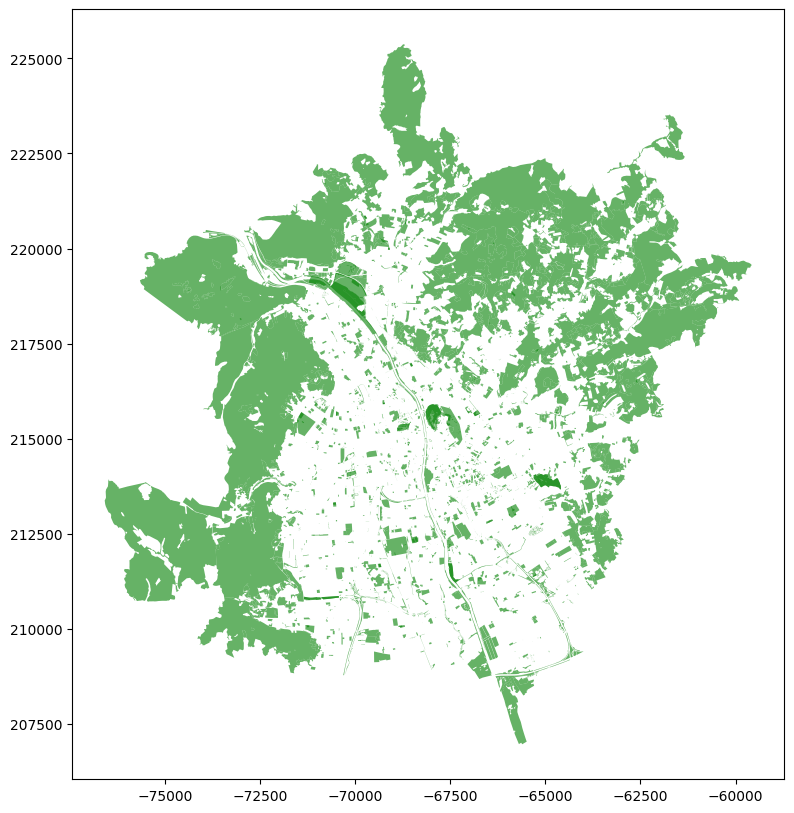

In [36]:
# Define tags for urban green spaces and parks
tags = {
    "leisure": ["park", "garden", "nature_reserve", "recreation_ground"],
    "landuse": ["forest", "grass", "meadow", "recreation_ground"]
}

tags = {
    "leisure": [
        "park",
        "garden",
        "nature_reserve",
        "recreation_ground",
        "pitch",          # often grassy sports fields
        "golf_course"
    ],
    "landuse": [
        "forest",
        "grass",
        "meadow",
        "recreation_ground",
        "allotments",
        "village_green",
        "cemetery"
    ],
    "natural": [
        "wood",
        "grassland",
        "scrub",
        "heath"
    ],
    "amenity": [
        "park",
        "playground"
        "graveyard"
    ]
}

# Download all green spaces in Graz & change the CRS
green_spaces = ox.features_from_place(place_name, tags=tags)
green_spaces = green_spaces[green_spaces.geometry.geom_type.isin(["Polygon", "MultiPolygon"])]
green_spaces = green_spaces.to_crs(epsg=31256)


# Quick visualization
green_spaces.plot(color='green', alpha=0.6, figsize=(10, 10))

In [51]:
map_green_spaces = KeplerGl(height=600)

map_green_spaces.add_data(data=green_spaces, name='green spaces')

map_green_spaces

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


c:\Users\vitad\studium\GST_S3\GAT2\venv-gst200b311\Lib\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(data={'green spaces': {'index': [('relation', 22203), ('relation', 1231619), ('relation', 1252339), (…

In [37]:
# Inspect data
green_spaces.info()
print(green_spaces.head())
print(green_spaces.columns)

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 4280 entries, ('relation', np.int64(22203)) to ('way', np.int64(1453823811))
Columns: 191 entries, geometry to managed
dtypes: geometry(1), object(190)
memory usage: 6.4+ MB
                                                           geometry amenity  \
element  id                                                                   
relation 22203    MULTIPOLYGON (((-65501.956 217899.938, -65503....     NaN   
         1231619  MULTIPOLYGON (((-67151.897 212730.969, -67113....     NaN   
         1252339  POLYGON ((-69251.105 212547.504, -69229.727 21...     NaN   
         1252342  POLYGON ((-69158.588 212189.28, -69169.839 212...     NaN   
         1263792  POLYGON ((-66492.198 214894.712, -66537.161 21...     NaN   

                 backrest                source level check_date operator  \
element  id                                                                 
relation 22203        NaN  GeoImage.at High-Res   NaN       

In [38]:
# Clean data
green_spaces = green_spaces[['geometry', 'amenity', 'leisure', 'landuse', 'natural', 'sport', 'name']]
print(green_spaces.head())


                                                           geometry amenity  \
element  id                                                                   
relation 22203    MULTIPOLYGON (((-65501.956 217899.938, -65503....     NaN   
         1231619  MULTIPOLYGON (((-67151.897 212730.969, -67113....     NaN   
         1252339  POLYGON ((-69251.105 212547.504, -69229.727 21...     NaN   
         1252342  POLYGON ((-69158.588 212189.28, -69169.839 212...     NaN   
         1263792  POLYGON ((-66492.198 214894.712, -66537.161 21...     NaN   

                 leisure     landuse natural sport                      name  
element  id                                                                   
relation 22203       NaN      forest     NaN   NaN                 Leechwald  
         1231619     NaN  allotments     NaN   NaN  Heimgartenverein Schönau  
         1252339     NaN    cemetery     NaN   NaN             Urnenfriedhof  
         1252342     NaN    cemetery     NaN   NaN 

In [39]:
print(green_spaces['sport'].unique())

[nan 'swimming' 'beachvolleyball' 'soccer' 'ballsport' 'running'
 'equestrian' 'tennis' 'golf' 'athletics' 'padel' 'basketball'
 'soccer;handball;volleyball' 'skateboard' 'multi' 'ice_stock'
 'basketball;soccer' 'basketball;handball;soccer' 'soccer;multi'
 'volleyball' 'streetball' 'ice_hockey' 'table_tennis' 'soccer; rugby'
 'cycling' 'soccer,basketball,handball' 'basketball;streetsoccer'
 'soccer;basketball;hockey;handball' 'tennis;streetsoccer' 'long_jump'
 'bmx' 'boules' 'soccer;basketball' 'handball' 'archery'
 'baseball;cricket' 'multi;basketball;football;handball'
 'basketball;soccer;multi' 'basketball;soccer;volleyball;multi'
 'soccer;field_hockey' 'bouldering' 'surfing' 'field_hockey' 'parkour'
 'soccer;field_hockey;handball;multi' 'fitness' 'multi;basketball']


In [46]:
# Remove invalid green areas after visual inspection
green_spaces = green_spaces[~green_spaces['name'].isin(['Merkur Arena'])]
green_spaces = green_spaces[green_spaces['sport'].isna() | green_spaces['sport'].isin(['soccer', 'equestrian', 'golf', 'soccer; rugby', 'baseball', 'bmx', 'rugby', 'cricket', 'archery', 'baseball;cricket'])]

In [49]:

# Extract public-accessible green spaces (parks, urban forests, cemeteries etc.)
public_green = green_spaces[
    (green_spaces["leisure"].isin(["park", "garden", "nature_reserve", "recreation_ground"])) |
    (green_spaces["landuse"].isin(["forest", "recreation_ground", "village_green", "cemetery"])) |
    (green_spaces["natural"].isin(["wood"])) |
    (green_spaces["amenity"].isin(["park", "playground", "graveyard"]))
]
# Drop private gardens without name
public_green = public_green[~((public_green["leisure"] == "garden") & (public_green["name"].isna()))]


In [50]:
map_public = KeplerGl(height=600)

map_public.add_data(data=public_green, name='public green spaces')

map_public

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


c:\Users\vitad\studium\GST_S3\GAT2\venv-gst200b311\Lib\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(data={'public green spaces': {'index': [('relation', 22203), ('relation', 1252339), ('relation', 1252…

In [ ]:
# Spatial join of green areas


# Classify green areas based on type of use (clean up data)
# Exclude areas like sport arenas
# Keep public green spaces (no entry fee; possibility to practice various leisure activities (sports, playgrounds))
# !! Include Natura 2000 areas?


# !! How to do deal with residential green areas? Take into account as green spaces but not for accessibility?

In [ ]:
# Get polygon of residential areas
tags_residential = {"landuse": ["residential"]}
residential_areas = ox.features_from_place(place_name, tags=tags_residential)

In [ ]:
# Get street network from osmnx

#!! Public transport routes?


In [ ]:
# Download population data for Graz (grid) and add as geodataframe


In [ ]:
# Get access points to green areas (Schnittpunkte von Wegen mit Parks)


# Method 1: Buffers

In [ ]:
# Create distance buffers of 300, 500 and 700 metres around the park access points


# Join buffers



In [ ]:
# Intersect buffers with residential areas

# Calculate area and percentage of green residential areas


# Calculate deficient area (not within 700 m of green space) in total and for each district



In [ ]:
# How much of residential areas are within each buffer?

In [ ]:
# Population within each distance?

# Method 2: Network Analysis

In [ ]:
# Create distance buffers of 300, 500 and 700 metres walking distance around the park access points
# 700 m seen as distance people are willing to walk to reach a green area

# Join buffers

In [ ]:
# Create distance buffers of 50, 150 and 300 metres walking distance around bus stations

Indicators:
total number of public parks
total area of public parks and gardens within a neighbourhood or within walking distance buffers
percentage of land covered by green spaces from the total urban area
total surface area of public parks within a neighbourhood relative to population.

# Results

In [ ]:
# Visualize green spaces in the city

In [ ]:
# Calculate the density of parks using Kernel density function

In [ ]:
# Relate data of green spaces to total area of city / districts


In [ ]:
# Population density map

In [ ]:
# Map of accessbility to green areas by foot (buffers, green areas and residential areas)

In [ ]:
# Map of population density and deficient areas

In [ ]:
# Choropleth map of deficient area percentage within each district